In [2]:
!pip install --upgrade pip
!pip install wheel
!sudo apt-get update
!sudo apt-get install gfortran -y
!sudo apt install make -y
!pip install camb
!pip install sbi
!pip install torch
!pip install healpy

Get:1 file:/etc/apt/mirrors/debian.list Mirrorlist [30 B]
Get:2 file:/etc/apt/mirrors/debian-security.list Mirrorlist [39 B]             
Hit:3 https://deb.debian.org/debian bookworm InRelease                         
Hit:7 https://packages.cloud.google.com/apt google-compute-engine-bookworm-stable InRelease
Hit:4 https://deb.debian.org/debian bookworm-updates InRelease
Hit:5 https://deb.debian.org/debian bookworm-backports InRelease
Hit:8 https://packages.cloud.google.com/apt cloud-sdk-bookworm InRelease
Hit:6 https://deb.debian.org/debian-security bookworm-security InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gfortran is already the newest version (4:12.2.0-3).
0 upgraded, 0 newly installed, 0 to remove and 3 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  make-doc
The following NEW packages will be installed:

In [12]:
import camb
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import numpy as np
import healpy as hp
from tqdm import tqdm

# Set the parameters for the CAMB simulation
def sim(params):
    # Create a set of cosmological parameters
    pars = camb.CAMBparams()
    H0 = params[0] * 100
    As = 1e-10*np.exp(params[3])
    pars.set_cosmology(H0=H0, ombh2=params[1], omch2=params[2])
    pars.InitPower.set_params(As=As, ns=params[4])
    pars.set_for_lmax(2500, lens_potential_accuracy=0)

    # Get the results from CAMB
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl = True)
    total = powers['total']
    cl = total[:, 0]
    #nside = 1024
    #cmb_map = hp.sphtfunc.synfast(cl, nside=nside)
    #cl_hat = hp.sphtfunc.anafast(cmb_map)

    return cl[2:2500]

def finite_derivative_calc_update(fiducial_vals, size):
    derivatives = []
    for i in tqdm(range(5)):
        step = size[i]
        parr = fiducial_vals.copy()
        parr[i] = fiducial_vals[i] + step
        parr2 = fiducial_vals.copy()
        parr2[i] = fiducial_vals[i] - step
        cl1 = sim(parr)
        cl2 = sim(parr2)
        derivative = (cl1 - cl2)/(2*step)
        derivatives.append(derivative.tolist())
    return derivatives

fiducial_values = [0.674,  0.0224,  0.120, 3.08, 0.965]
finite_param_steps = [0.0025, 0.0002, 0.0005, np.log(0.5), 0.001]
fiducial_cls = sim(fiducial_values)
finite_derivative = finite_derivative_calc_update(fiducial_values, finite_param_steps)

def cov_matrix(vals):
    ells = np.arange(2561)[2:2500]
    V = np.diag(8*np.pi**2*vals**2 / (ells**2*(ells+1)**2*(2*ells+1)))
    return V

def MOPED(obs):
    obs = obs
    d_minus_mu = obs - fiducial_cls
    d_minus_mu_vector = [[i] for i in d_minus_mu ]
    inverse_cov_matrix = np.linalg.inv(cov_matrix(obs))
    term1 = np.matmul(inverse_cov_matrix, d_minus_mu_vector)
    compressed_stat = np.matmul(finite_derivative, term1)
    result =  [item[0] for item in compressed_stat]
    return result

# Define your parameter space
parameter_min = [0.60, 0.02, 0.1, 3.05, 0.9]
parameter_max = [0.80, 0.025, 0.15,3.11, 1.0]

# Define prior for all parameters
prior = utils.BoxUniform(low=torch.as_tensor(parameter_min),
                         high=torch.as_tensor(parameter_max))

# Define your simulation function
def simulation_wrapper(params):
    return MOPED(sim(params))

100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.37s/it]


In [13]:
# Your observed parameter values
observed_params = torch.tensor([0.676, 0.0220, 0.122, 3.085, 0.964])

# Generate the observed dataset
observed_dataset = simulation_wrapper(observed_params)
print(observed_dataset )


[3.0526152538330464e+16, -4.651229485181843e+17, 9.866749074662946e+16, -1.8675902096736216e+16, -2.0995195633005468e+16]


Running 3000 simulations.: 100%|███████████████████████████████████████████████████████| 3000/3000 [1:18:56<00:00,  1.58s/it]


 Neural network successfully converged after 189 epochs.

Drawing 1000 posterior samples: 1103it [00:00, 41432.92it/s]                                                                 


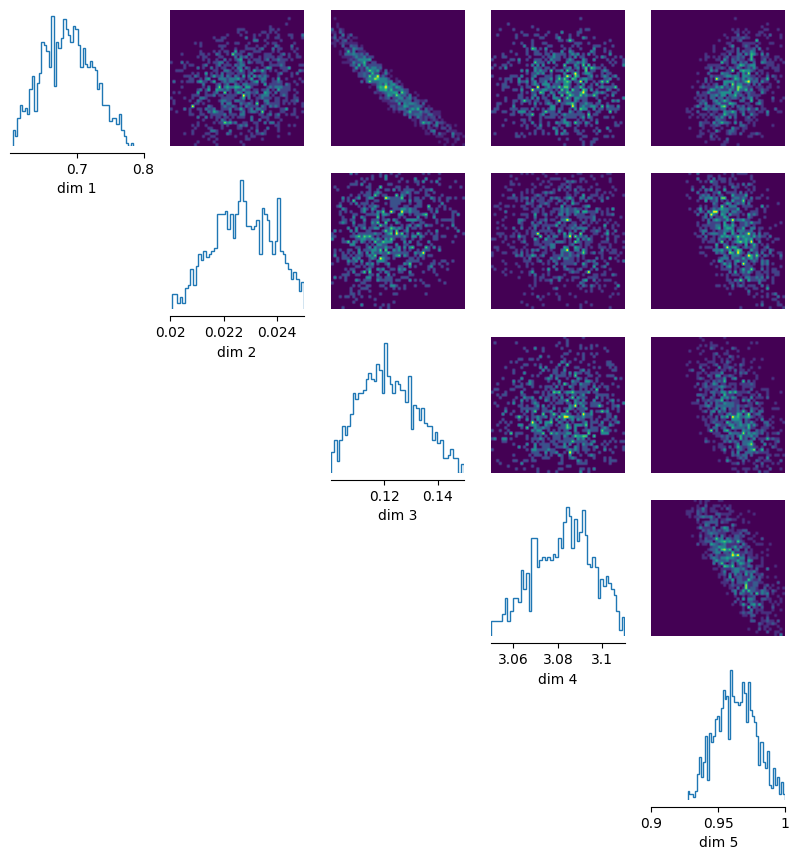

In [14]:
# Run SBI to perform inference
posterior = infer(simulation_wrapper, prior, method='SNPE',
                  num_simulations=3000, num_workers=1)

# Draw samples from the posterior
samples = posterior.sample((1000,), x=observed_dataset)

np.save('sbi_moped.npy', samples)

# Analyze the results (for example, by plotting the posterior)
limits_plot = [[parameter_min[i], parameter_max[i]] for i in range(len(parameter_min))]
_ = analysis.pairplot(samples, limits=limits_plot,
                      figsize=(10,10))

In [28]:
samples_5000 = posterior.sample((200000,), x=observed_dataset)

Drawing 200000 posterior samples: 201273it [00:07, 25475.33it/s]                                                             


In [30]:
samples_1000 = np.load('sbi_moped.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'sbi_moped_1000.npy'

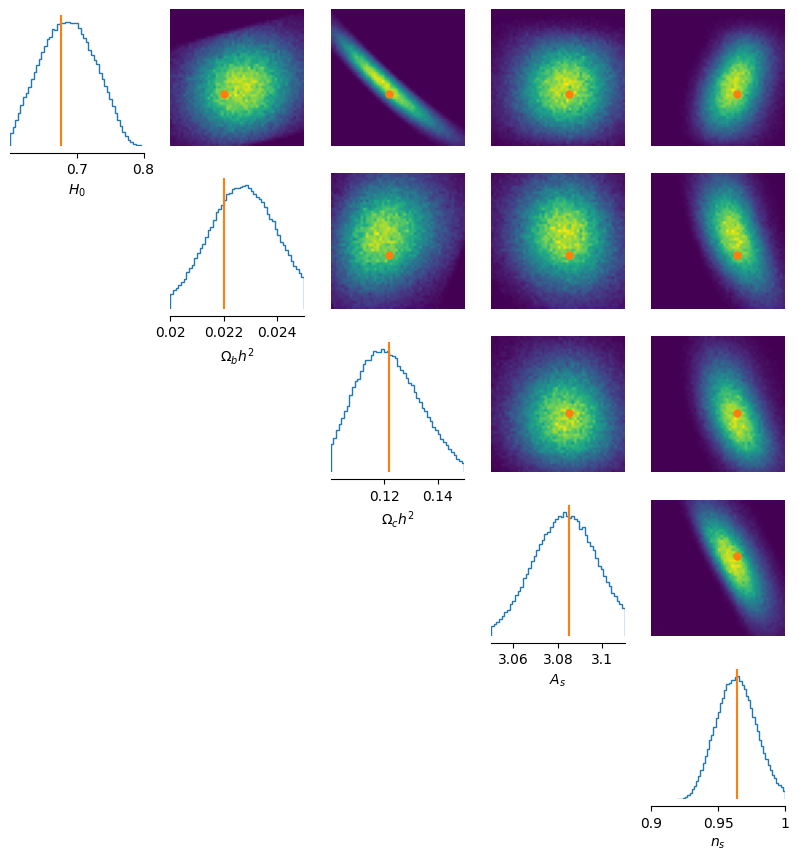

In [29]:
_ = analysis.pairplot( samples_5000, limits=limits_plot,figsize=(10,10), labels = [r'$H_0$', r'$\Omega_b h^2$', r'$\Omega_c h^2$',
                                                                                   r'$A_s$', r'$n_s$'], 
                      offdiag = 'hist', points = observed_params, colour = 'red')

In [31]:
np.save('sbi_moped_200000.npy', samples_5000) 

In [32]:
print(type(posterior))

<class 'sbi.inference.posteriors.direct_posterior.DirectPosterior'>


In [33]:
import pickle

with open('posterior_3000_SNPE_moped_no_noise.pkl', 'wb') as file:
    pickle.dump(posterior, file)